# 1. Imports and Configuration


In [1]:
!pip install -U efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=182168c6d93a83ff3da317cc81b161aee91b9fd1bfae80cde069d7d801c7c6a1
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
Successfully built efficientnet-pytorch


In [2]:
import os
import pandas as pd
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, random_split
from torch.autograd import Variable
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

from efficientnet_pytorch import EfficientNet


from collections import OrderedDict

import torch.nn.functional as F


# We are using this image dataset that has already been treated so that every image has the same size
base_dir = '/kaggle/input/jpeg-melanoma-384x384/'
# Running everything on the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Model saving/loading path
PATH = 'efficient_net.pth'

In [3]:
# This is the largest base2 we can fit in GPU memory
BATCH_SIZE = 16
NUM_EPOCHS = 30
# Early stopping patience
PATIENCE = 5
learning_rate = 0.001
loss_func = nn.BCELoss()
random_seed = 42

# 2. Load Data

In [4]:
# Here we are defining how we will load our data
class CustomImageDataset(Dataset):
    def __init__(self, path, image_names, labels=None, transforms=None):
        super().__init__()
        self.path = path
        self.image_names = image_names
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, idx: int):
        # We simply return the image and label for the given index
        im_path = os.path.join(self.path, self.image_names[idx] + '.jpg')
        image = cv2.imread(im_path)

        if self.transforms:
            image = self.transforms(image)
            
        if self.labels is None: 
            # Or just the image if we don't have labels (test set)
            return image
        return image, float(self.labels[idx])

    def __len__(self) -> int:
        return self.image_names.shape[0]

    def get_labels(self):
        return list(self.labels)

# Set up Transformations

In [5]:
class Microscope:
    """
    Cutting out the edges around the center circle of the image
    Imitating a picture, taken through the microscope

    Args:
        p (float): probability of applying an augmentation
    """

    def __init__(self, p: float = 0.5):
        self.p = p

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to apply transformation to.

        Returns:
            PIL Image: Image with transformation.
        """
        if random.random() < self.p:
            circle = cv2.circle((np.ones(img.shape) * 255).astype(np.uint8), # image placeholder
                        (img.shape[0]//2, img.shape[1]//2), # center point of circle
                        random.randint(img.shape[0]//2 - 3, img.shape[0]//2 + 15), # radius
                        (0, 0, 0), # color
                        -1)

            mask = circle - 255
            img = np.multiply(img, mask)
        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(p={self.p})'
    
class DrawHair:
    """
    Draw a random number of pseudo hairs

    Args:
        hairs (int): maximum number of hairs to draw
        width (tuple): possible width of the hair in pixels
    """

    def __init__(self, hairs:int = 4, width:tuple = (1, 2)):
        self.hairs = hairs
        self.width = width

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        if not self.hairs:
            return img
        
        width, height, _ = img.shape
        
        for _ in range(random.randint(0, self.hairs)):
            # The origin point of the line will always be at the top half of the image
            origin = (random.randint(0, width), random.randint(0, height // 2))
            # The end of the line 
            end = (random.randint(0, width), random.randint(0, height))
            color = (0, 0, 0)  # color of the hair. Black.
            cv2.line(img, origin, end, color, random.randint(self.width[0], self.width[1]))
        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, width={self.width})'
    
class AdvancedHairAugmentation:
    """
    Impose an image of a hair to the target image

    Args:
        hairs (int): maximum number of hairs to impose
        hairs_folder (str): path to the folder with hairs images
    """

    def __init__(self, hairs: int = 5, hairs_folder: str = ""):
        self.hairs = hairs
        self.hairs_folder = hairs_folder

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        n_hairs = random.randint(0, self.hairs)
        
        if not n_hairs:
            return img
        
        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]
        
        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(hair_images)))
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask
            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of hair in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of hair from hair image.
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            # Put hair in ROI and modify the target image
            dst = cv2.add(img_bg, hair_fg)

            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
                
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, hairs_folder="{self.hairs_folder}")'

In [6]:
# Reading metadata
train_df_csv = pd.read_csv(base_dir + 'train.csv') 
test_df_csv = pd.read_csv(base_dir + 'test.csv') 

# Preprocessor for images
train_transform = transforms.Compose([
    AdvancedHairAugmentation(hairs_folder='/kaggle/input/melanoma-hairs'),
    Microscope(p=0.5),
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(size=384, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

# Define datasets
ds_train = CustomImageDataset(
    path= base_dir + 'train/',
    image_names=train_df_csv.image_name.values,
    labels=train_df_csv.target.values,
    transforms=train_transform
)
ds_test = CustomImageDataset(
    path= base_dir + 'test/',
    image_names=test_df_csv.image_name.values,
    transforms=test_transform
)


# Split into train/validation
len_ds=len(ds_train)
len_train=int(0.85*len_ds)
len_val=len_ds-len_train

torch.manual_seed(random_seed)
ds_train,ds_val=random_split(ds_train,[len_train,len_val])

# Create the data loaders that will provide us with data in batches to reduce memory usage
# Note that we only shuffle the training set, the rest is unecessary 
train_loader = torch.utils.data.DataLoader(ds_train, batch_size = BATCH_SIZE, shuffle = True)
val_loader = torch.utils.data.DataLoader(ds_val, batch_size = BATCH_SIZE*2, shuffle = False)
test_loader = torch.utils.data.DataLoader(ds_test, batch_size = BATCH_SIZE*2, shuffle = False)

In [7]:
# Treat metadata for the XGB further down the line

# Fill nulls
train_df_csv['sex'].fillna('male', inplace=True)
test_df_csv['sex'].fillna('male', inplace=True)

train_df_csv['age_approx'].fillna(train_df_csv['age_approx'].mode().values[0], inplace=True)
test_df_csv['age_approx'].fillna(test_df_csv['age_approx'].mode().values[0], inplace=True)

train_df_csv['anatom_site_general_challenge'].fillna('torso', inplace=True)
test_df_csv['anatom_site_general_challenge'].fillna('torso', inplace=True)

# Normalize age
train_df_csv['age_enc'] = train_df_csv['age_approx'] / np.mean(train_df_csv['age_approx'])
test_df_csv['age_enc'] = test_df_csv['age_approx'] / np.mean(test_df_csv['age_approx'])

# Encode categorical to one hot

train_df_csv = pd.get_dummies(train_df_csv, columns=['sex', 'anatom_site_general_challenge'])
test_df_csv = pd.get_dummies(test_df_csv, columns=['sex', 'anatom_site_general_challenge'])

# Create the sets
X_train_full = train_df_csv[list(train_df_csv.columns[9:])]
y_train_full = train_df_csv.target

X_test = test_df_csv[list(test_df_csv.columns[5:])]

# Train/ validation split
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.15, random_state=random_seed)

# 3. Setup Efficient Net

In [8]:
class CustomEfficientNet(nn.Module):
    def __init__(self):
        super().__init__()
        # We use the backbone from the pretrained efficient net
        self.arch = EfficientNet.from_pretrained('efficientnet-b1')
        
        # And add to it a final linear layer
        self.arch._fc = nn.Linear(in_features=1280, out_features=500, bias=True)
        
        # And this will be our output
        self.ouput = nn.Linear(500, 1)
        
    def forward(self, x):
        # We simply go through the efficient net and through our linear layer
        x = self.arch(x)
        x = self.ouput(x)
        # We return a sigmoid so that we can have a result from 0-1
        return torch.sigmoid(x)
    

# Actually define the model and send it to the GPU
model = CustomEfficientNet()
model.to(device)

# Use Adam optimizer with a decreasing learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='max', patience=1, verbose=True, factor=0.2)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/checkpoints/efficientnet-b1-f1951068.pth



Loaded pretrained weights for efficientnet-b1


# 4. Train Efficient Net

In [9]:
def accuracy_batch(output, target):
    # Create an accuracy score for the batch
    
    # get output class
    pred = torch.round(output)
    
    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects


def auc_epoch(output, target):
    # Create AUC for the given epoch
    #     Note that we can't do this for a batch since it may not have 
    #     all classes defined
    return roc_auc_score(target, output)

def train_val(epochs, model, loss_func, opt, train_dl, val_dl, sanity_check=False):    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # history of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }
    
    # initialize best loss to a small value
    best_metric=float('-inf')
    
    # initialize patience
    patience = PATIENCE
    
    # The actual training loop
    for epoch in range(epochs):
        # train model on training dataset
        model.train()
        train_loss,train_metric=loss_epoch(model,loss_func,train_dl,opt)
        
        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate model on validation dataset    
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model, loss_func, val_dl)
            
        # Update our learning rate
        scheduler.step(val_metric)
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # Print epoch metrics
        print("epoch: %d, train loss: %.6f, val loss: %.6f, roc_auc: %.2f" %(epoch, train_loss, val_loss, val_metric))
        
        # store if it is our best model
        if val_metric > best_metric:
            patience = PATIENCE
            best_metric = val_metric
            # store weights into a local file
            torch.save(model.state_dict(), PATH)
            print("Copied best model weights!")
        else: 
            # If our score didn't improve we will update our patience
            patience -= 1
            if patience == 0:
                # If we reach our patience limit then do early stopping
                print("Early stopping, best Val roc: {:-3f}".format(best_metric))
                break
       
    return model, loss_history, metric_history, epoch


def loss_epoch(model,loss_func,dataset_dl,opt=None, sanity_check=False):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)
    
    # If we are validating the epoch we want to keep the predictions and targets
    #     to send them to our AUC calculation
    if opt is None: 
        val_preds = []
        targets = []

    # Run through one epoch
    for xb, yb in tqdm(dataset_dl):
        # move batch to device
        xb=xb.to(device)
        yb=Variable(yb).float()
        yb=yb.to(device)
        
        # get model output
        output=model(xb)
        
        # Save the preds and targets if validating
        if opt is None:
            val_preds += list(output.cpu().detach())
            targets += list(yb.cpu().detach())
        
        # get loss per batch
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        if metric_b is not None and opt is not None:
            running_metric+=metric_b

        # break the loop in case of sanity check
        if sanity_check is True:
            break
    
    # average loss value
    loss=running_loss/float(len_data)
    
    # average metric value
    if opt is not None: 
        metric=running_metric/float(len_data)
    # If validating we want to calculate the AUC
    else: 
        metric= auc_epoch(val_preds, targets)
    
    return loss, metric


def loss_batch(loss_func, output, target, opt=None):
    # get loss 
    loss = loss_func(output, target.unsqueeze(1))
    
    # get performance metric
    metric_b = accuracy_batch(output,target)
    
    # Do the back propagation
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [10]:
model, loss_history, metric_history, epochs_ran = train_val(NUM_EPOCHS, model, loss_func, optimizer, train_loader, val_loader)


epoch: 0, train loss: 0.005676, val loss: 0.003370, roc_auc: 0.78
Copied best model weights!



epoch: 1, train loss: 0.005010, val loss: 0.002730, roc_auc: 0.84
Copied best model weights!



epoch: 2, train loss: 0.004895, val loss: 0.002866, roc_auc: 0.77



epoch: 4, train loss: 0.004784, val loss: 0.003005, roc_auc: 0.72



epoch: 6, train loss: 0.004463, val loss: 0.002406, roc_auc: 0.88
Copied best model weights!



Epoch    13: reducing learning rate of group 0 to 4.0000e-05.
epoch: 12, train loss: 0.004230, val loss: 0.002332, roc_auc: 0.89



epoch: 16, train loss: 0.004054, val loss: 0.002340, roc_auc: 0.89


# 5. Evaluate Efficient Net

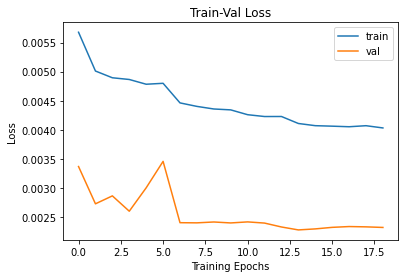

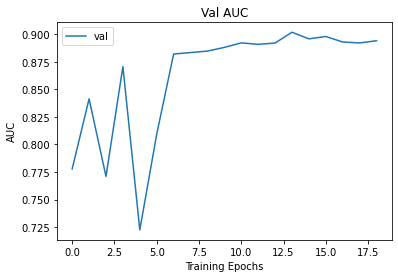

In [11]:
# Train-Validation Progress

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(0,epochs_ran+1),loss_history["train"],label="train")
plt.plot(range(0,epochs_ran+1),loss_history["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot auc progress

plt.title("Val AUC")
plt.plot(range(0,epochs_ran+1),metric_history["val"],label="val")
plt.ylabel("AUC")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()


In [12]:
# Run our model through our validation set and check our AUC
total_outputs = []
total_labels = []
with torch.no_grad():
    for i, data in enumerate(tqdm(val_loader), 0):
        # Get the prediction
        inputs, labels = data
        inputs = inputs.to(device)
        output = model(inputs)
        
        #Move the prediction back to the cpu and append it to the list
        output = output.cpu().detach()
        total_outputs += list(output)
        total_labels += labels

print('roc score:',roc_auc_score(total_labels, total_outputs))


roc score: 0.9028287380915577


# 6. Setup XGB and train XGB

In [13]:
# These parameters were tuned by using GridSearch (Thanks to @Md Awsafur Rahman)
xgb = XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.002, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=None, monotone_constraints=None,
             n_estimators=700, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method=None, validate_parameters=False, verbosity=None)

xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.002, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=None, monotone_constraints='()',
             n_estimators=700, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=False, verbosity=None)

# 7. Create Submission with ensemble

In [14]:
# Run our Neural Net model throught the Test set and get the predictions
net_outputs = []
with torch.no_grad():
    for i, data in enumerate(tqdm(test_loader), 0):
        inputs = data
        inputs = inputs.to(device)

        output = model(inputs)
        net_outputs += output

# Get predictions back from GPU
preds_net = [output.data.cpu().numpy().item() for output in net_outputs]

# Get XGB predictions
preds_xgb = xgb.predict(X_test)

# Create Dataframe with predictions
pred_df = pd.DataFrame({'image_name': test_df_csv.image_name, 'preds_net': preds_net, 'preds_xgb': preds_xgb})
# Set the final target as a result from both our models
pred_df['target'] = (pred_df['preds_net'] * 0.9) + (pred_df['preds_xgb'] * 0.1)

# Create the csv file to submit
pred_df[['image_name', 'target']].to_csv('submission_ensemble.csv', index=False)

# Create csv with only nn to check if its better
pred_df['target'] = pred_df['preds_net']
pred_df[['image_name', 'target']].to_csv('submission_efficientNet.csv', index=False)

# 8. Extras and Experiments


In [15]:
# Augment data 
# Wheights for classes


In [16]:
# LOADING MODEL
#model = CustomEfficientNet()
#model.load_state_dict(torch.load('/kaggle/input/very-simple-pytorch-efficientnet//efficient_net.pth'))
#model.to(device)
